## Package Imports

In [55]:
import os
import pandas as pd

## Local Imports

In [56]:
from clock.config import connect

## Configuration

In [57]:
%load_ext autoreload
#%autoreload 0 # -- Default
#%autoreload 1 # --Only auto-reload modules imported using aimport
%autoreload 2 # --Auto-reload all modules



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
engine, session = connect()

# Attendance
Attendance here is defined as someone who shows up for work in a given day, even if it is for
only a few minutes.

In [59]:
sql = '''
with frequency as (
    select total_days
         , count(employee_id) as frequency
    from attendance
    group by total_days
    order by total_days
), add_bins as (
    select case
               when total_days >= 240 and total_days <= 249 then '240-249'
               when total_days >= 250 and total_days <= 259 then '240-259'
               when total_days >= 260 and total_days <= 269 then '260-269'
               when total_days >= 270 and total_days <= 279 then '270-279'
               when total_days >= 280 and total_days <= 289 then '280-289'
               when total_days >= 290 and total_days <= 299 then '290-299'
               when total_days > 300 then '300+'
        end as bin
         , frequency
    from frequency
)
select bin
     , sum(frequency) as frequency
from add_bins
group by bin;

'''
df = pd.read_sql_query(sql, con=engine)

 We can see that this follows a normal distribution, centered around the 270
 days of total attendance, with a few in the 240s and 290+.

<AxesSubplot:xlabel='bin'>

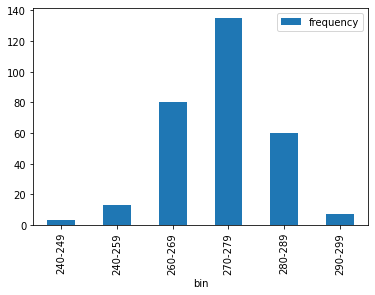

In [60]:
df.plot(x='bin', y='frequency', kind='bar')

We can take a look at the top 25 performers and see that universally they had 1100+ hours per year.

In [61]:
sql = '''
select employee_id
      , yearly_floor_time_hours
     , rank_best
from best_worst_25
where rank_best <= 25
order by rank_best;
'''
df = pd.read_sql_query(sql, con=engine)

In [62]:
df

,employee_id,yearly_floor_time_hours,rank_best
0,170,1187,1
1,118,1166,2
2,187,1159,3
3,248,1149,4
4,233,1146,5
5,40,1141,6
6,96,1140,7
7,84,1133,8
8,152,1131,9
9,59,1129,10


<AxesSubplot:xlabel='rank_best'>

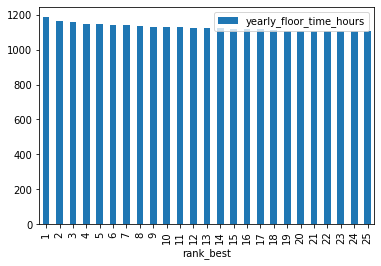

In [63]:
df.plot(x='rank_best', y='yearly_floor_time_hours', kind='bar')

In [64]:
sql = '''
select employee_id
      , yearly_floor_time_hours
from best_worst_25
where rank_worst <= 25;
'''


We can take a look at the bottom 25 performers and see that there was little variance from
person-to-person; all had around 900-1000 hours annually:

In [65]:
sql = '''
select employee_id
      , yearly_floor_time_hours
     , rank_worst
from best_worst_25
where rank_worst <= 25
order by rank_worst;
'''
df = pd.read_sql_query(sql, con=engine)

In [66]:
df

,employee_id,yearly_floor_time_hours,rank_worst
0,271,903,1
1,176,906,2
2,50,925,3
3,88,940,4
4,189,941,5
5,237,943,6
6,139,947,7
7,128,949,8
8,193,951,9
9,30,951,10


<AxesSubplot:xlabel='rank_worst'>

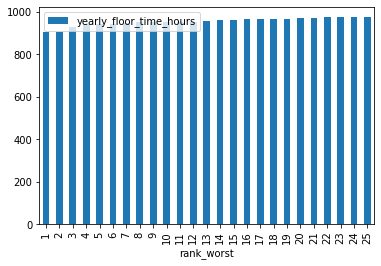

In [67]:
df.plot(x='rank_worst', y='yearly_floor_time_hours', kind='bar')

In [68]:
sql = '''
select employee_id
      , yearly_floor_time_hours
from best_worst_25
where rank_worst <= 25;
'''

# Hour Aggregations
## By Week

Looking at the weekly hours, we can see that the average follows the same basic pattern as the
the totals.  Workers are on the floor typically for 3.75 to 4 hours a day on average.
Similarly, while there are peaks and valleys for totals, the range is only from 5700 to 6200
hours per week. The effect is magnified in the visualization due to the non-zero Y axis.

Note that we omit week 1 and 52 because they are not a full week, and therefore give the
appearance of being an outlier when plotted.

In [79]:
sql = """
select week_num,
       average_floor_time_seconds * 1.0 / 60 / 60  as avg_floor_time_hours,
       total_floor_time_seconds / 60 / 60  as total_floor_time_hours,
       min_floor_time_seconds,
       max_floor_time_seconds
from weekly_aggregate
where week_num != '52'
and week_num != '00'"""
df = pd.read_sql(sql, con=engine)

<AxesSubplot:xlabel='week_num'>

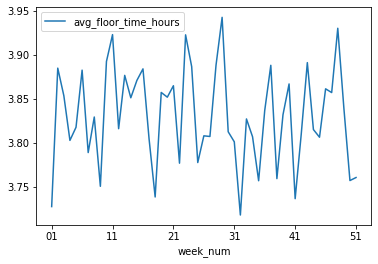

In [80]:
df.plot(x='week_num', y='avg_floor_time_hours', kind='line')

<AxesSubplot:xlabel='week_num'>

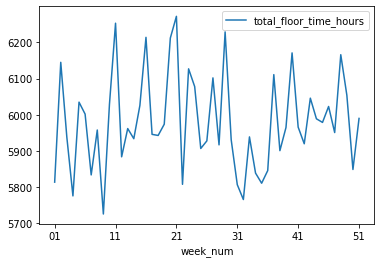

In [81]:
df.plot(x='week_num', y='total_floor_time_hours')

## By Month
When we aggregate at the month level, the averages also closely follow the totals. While the
graphs below look like there are large differences in averages, the range is small, from 3.80 to
 3.88 hours.  That's only a .08 hour difference, or ~5 minutes. Similarly, the total hours
 ranges between 24000 and 26500 hours total.

In [72]:
sql = """
select month_num,
       average_floor_time_seconds * 1.0 / 60 / 60  as avg_floor_time_hours,
       total_floor_time_seconds / 60 / 60  as total_floor_time_hours,
       min_floor_time_seconds,
       max_floor_time_seconds
from monthly_aggregate"""
df = pd.read_sql(sql, con=engine)

<AxesSubplot:xlabel='month_num'>

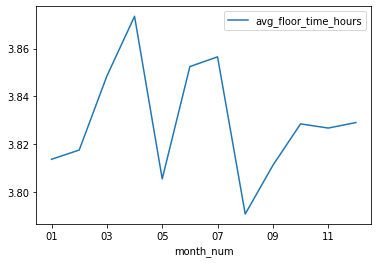

In [73]:
df.plot(x='month_num', y='avg_floor_time_hours', kind='line')

<AxesSubplot:xlabel='month_num'>

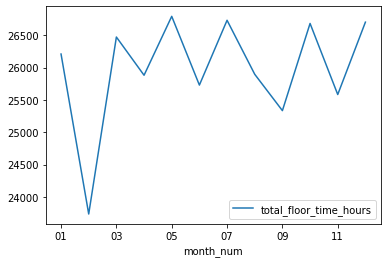

In [74]:
df.plot(x='month_num', y='total_floor_time_hours')